In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tifffile import imread
import zipfile

%load_ext tensorboard

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

2023-09-02 00:54:36.046210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


We create a N2V_DataGenerator object to help load data and extract patches for training and validation.

In [2]:
datagen = N2V_DataGenerator()

The data generator provides two methods for loading data: `load_imgs_from_directory` and `load_imgs`. Let's look at their docstring to figure out how to use it.

The SEM images are all in one directory, so we'll use `load_imgs_from_directory`. We'll pass in that directory (`"data/SEM/train"`), our image matches the default filter (`"*.tif"`) so we do not need to specify that. But our tif image is a stack of several images, so as dims we need to specify `"TYX"`.
If you're using your own data adapt this part to match your use case. If these functions aren't suitable for your use case load your images manually.
Feel free to ask a TA for help if you're unsure how to get your data loaded!

In [3]:
imgs = datagen.load_imgs_from_directory('/mnt/efs/shared_data/hack/data/20230811/raw/', filter='*.tiff', dims='ZYX')

print(f"Loaded {len(imgs)} images.")
print(f"First image has shape {imgs[0].shape}")

Loaded 5 images.
First image has shape (1, 64, 1024, 1024, 1)


The method returned a list of images, as per the doc string the dimensions of each are "SYXC". However, we only want to use one of the images here since Noise2Void is designed to work with just one acquisition of the sample. Let's use the first image at $1\mu s$ scantime.

In [49]:
img = np.asarray(imgs)
img = img[0,0,32]
print(f"First image has shape {img.shape}")

First image has shape (1024, 1024, 1)


For generating patches the datagenerator provides the methods `generate_patches` and `generate_patches_from_list`. As before, let's have a quick look at the docstring

Our `imgs` object is a list, so `generate_patches_from_list` is the suitable function.

In [4]:
#patches = datagen.generate_patches_from_list(imgs, shape=(96, 96))
patches = datagen.generate_patches_from_list(imgs,num_patches_per_img=128, augment=False,shape=(64, 64,64))

Generated patches: (128, 64, 64, 64, 1)
Generated patches: (128, 64, 64, 64, 1)
Generated patches: (128, 64, 64, 64, 1)
Generated patches: (128, 64, 64, 64, 1)
Generated patches: (128, 64, 64, 64, 1)


In [11]:
X.shape

(576, 64, 128, 128, 1)

In [5]:
# split into training and validation
n_train = int(round(0.9 * patches.shape[0]))
X, X_val = patches[:n_train, ...], patches[n_train:, ...]

As per usual, let's look at a training and validation patch to make sure everything looks okay.

Text(0.5, 1.0, 'Validation patch')

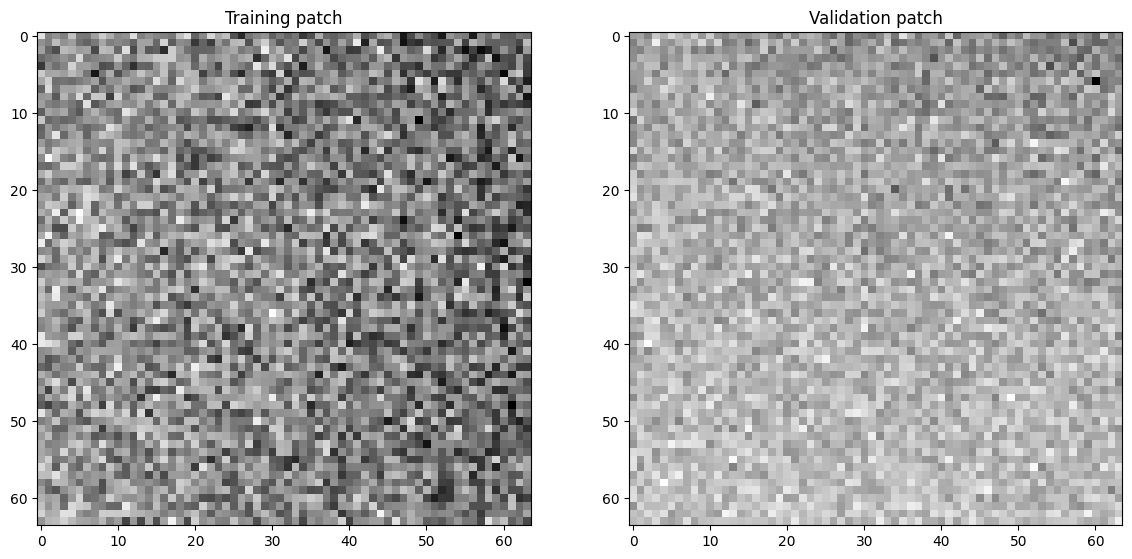

In [19]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(X[np.random.randint(X.shape[0]), ..., 0].mean(axis=0), cmap="gray_r")
plt.title("Training patch")
plt.subplot(1, 2, 2)
plt.imshow(X_val[np.random.randint(X_val.shape[0]), ..., 0].mean(axis=0), cmap="gray_r")
plt.title("Validation patch")

<hr style="height:2px;">

## Part 2: Configure and train the Noise2Void Network

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> the library will extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network.


Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> (e.g. 128) and <code>batch_norm</code>.

To keep the network from learning the identity we have to manipulate the input pixels for the blindspot during training. How to exactly manipulate those values is controlled via the <code>n2v_manipulator</code> parameter with default value <code>'uniform_withCP'</code> which samples a random value from the surrounding pixels, including the value at the control point. The size of the  surrounding area can be configured via <code>n2v_neighborhood_radius</code>.

The [paper supplement](https://arxiv.org/src/1811.10980v2/anc/supp_small.pdf) describes other pixel manipulators as well (section 3.1). If you want to configure one of those use the following values for <code>n2v_manipulator</code>:
* <code>"normal_additive"</code> for Gaussian (<code>n2v_neighborhood_radius</code> will set sigma)
* <code>"normal_fitted"</code> for Gaussian Fitting
* <code>"normal_withoutCP"</code> for Gaussian Pixel Selection

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

---
<div class="alert alert-block alert-info"><h4>
    TASK 3.2</h4>
    <p>
As suggested look at the docstring of the N2VConfig and then generate a configuration for your Noise2Void network, and choose a name to identify your model by.
    </p>
</div>

In [7]:

config = N2VConfig(X,
                  train_batch_size=4,
                  batch_norm=True,
                  n2v_manipulator='normal_additive',
                  train_steps_per_epoch=40,
                  train_epochs=50 
                  )
vars(config)
model_name = "neuromast_3D"

---

In [8]:
# initialize the model
model = N2V(config, model_name, basedir="models")

/home/rachelb/conda/envs/03_image_restoration_part2/lib/python3.7/site-packages/n2v/models/n2v_standard.py:430: UserWarning: output path for model already exists, files may be overwritten: /home/rachelb/DL-MBL-2023/03_image_restoration/models/neuromast_3D
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
2023-09-02 00:55:41.362373: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-02 00:55:41.365728: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-02 00:55:41.415922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-02 00:55:41.417513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name:

Now let's train the model and monitor the progress in tensorboard.
Adapt the command below as you did before.

In [9]:
history = model.train(X_val, X_val)

3932 blind-spots will be generated per training patch of size (64, 64, 64).


Preparing validation data: 100%|██████████| 64/64 [00:00<00:00, 77.17it/s]
2023-09-02 00:55:49.038348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-02 00:55:49.061319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/50


2023-09-02 00:55:51.214814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-09-02 00:56:00.417017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-02 00:56:01.404358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


40/40 [==============================] - 46s 769ms/step - loss: 0.5631 - n2v_mse: 0.9896 - n2v_abs: 0.5631 - val_loss: 0.2746 - val_n2v_mse: 0.2397 - val_n2v_abs: 0.2746
Epoch 2/50
40/40 [==============================] - 25s 631ms/step - loss: 0.1885 - n2v_mse: 0.1203 - n2v_abs: 0.1885 - val_loss: 0.2286 - val_n2v_mse: 0.2434 - val_n2v_abs: 0.2286
Epoch 3/50
40/40 [==============================] - 26s 645ms/step - loss: 0.1697 - n2v_mse: 0.1240 - n2v_abs: 0.1697 - val_loss: 0.2487 - val_n2v_mse: 0.2348 - val_n2v_abs: 0.2487
Epoch 4/50
40/40 [==============================] - 26s 660ms/step - loss: 0.1687 - n2v_mse: 0.1328 - n2v_abs: 0.1687 - val_loss: 0.2248 - val_n2v_mse: 0.2023 - val_n2v_abs: 0.2248
Epoch 5/50
40/40 [==============================] - 27s 674ms/step - loss: 0.1598 - n2v_mse: 0.1100 - n2v_abs: 0.1598 - val_loss: 0.2145 - val_n2v_mse: 0.2329 - val_n2v_abs: 0.2145
Epoch 6/50
40/40 [==============================] - 28s 693ms/step - loss: 0.1622 - n2v_mse: 0.1268 - n2v_

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


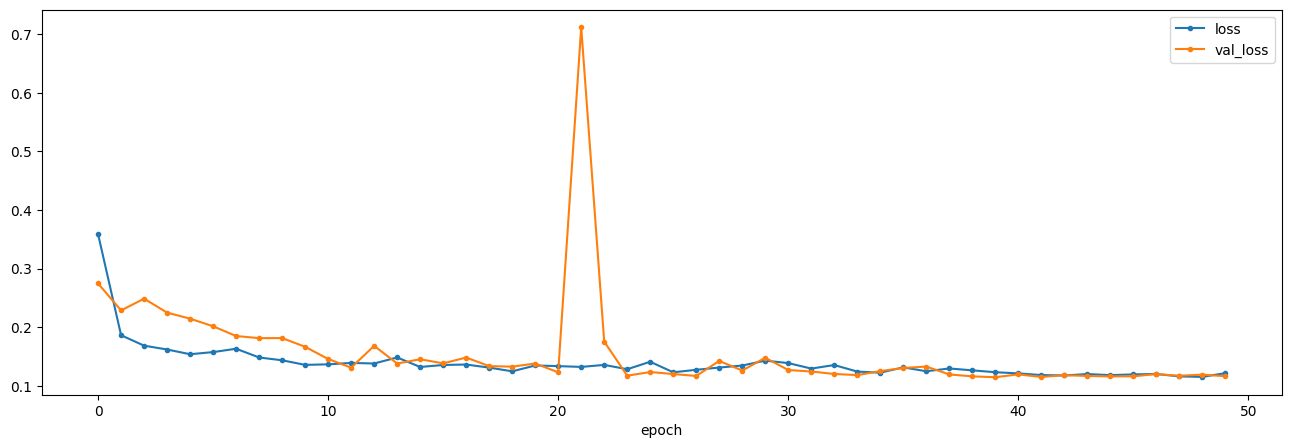

In [10]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16, 5))
plot_history(history, ["loss", "val_loss"])

<hr style="height:2px;">

## Part 3: Prediction

Similar to CARE a previously trained model is loaded by creating a new N2V-object without providing a `config`.

In [11]:
model = N2V(config=None, name=model_name, basedir="models")

Loading network weights from 'weights_best.h5'.


Let's load a $1\mu s$ scantime test images and denoise them using our network and like before we'll use the high SNR image to make a quantitative comparison. If you're using your own data and don't have an equivalent you can ignore that part.

In [31]:
#test_img = imread("data/SEM/test/test.tif")[2, ...]
#test_img_highSNR = imread("data/SEM/test/test.tif")[-1, ...]
test_img = np.asarray(imgs)
print(f"Loaded test image with shape {test_img.shape}")

Loaded test image with shape (5, 1, 64, 1024, 1024, 1)


In [32]:
#test_img = test_img[0,0,:,:,0]
#test_img.shape
predictions = []
for i in range(test_img.shape[0]):  
    test_denoised = model.predict(test_img[i,0,...,0], axes="ZYX", n_tiles=(1,2,2))
    predictions.append(test_denoised)

100%|██████████| 4/4 [00:11<00:00,  3.00s/it]    


Let's look at the results

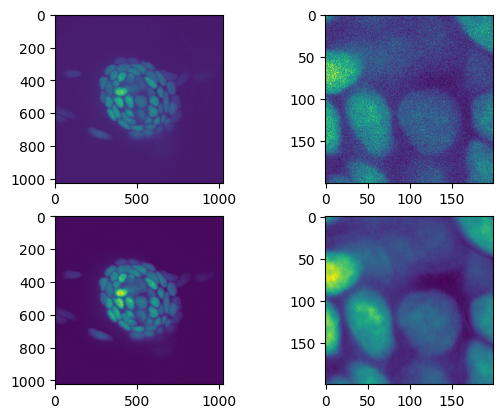

In [26]:
fig, ax = plt.subplots(2,2)
ax[0][0].imshow(test_img[0,0,32,...,0])
#ax[0][0].set_title('raw image')
ax[0][1].imshow(test_img[0,0,32,400:600,400:600,0])
#ax[0][1].set_title('raw image crop')
ax[1][0].imshow(test_denoised[32,...])
#ax[1][0].set_title('denoised image')
ax[1][1].imshow(test_denoised[32,400:600,400:600])
#ax[1][1].set_title('denoised image crop')

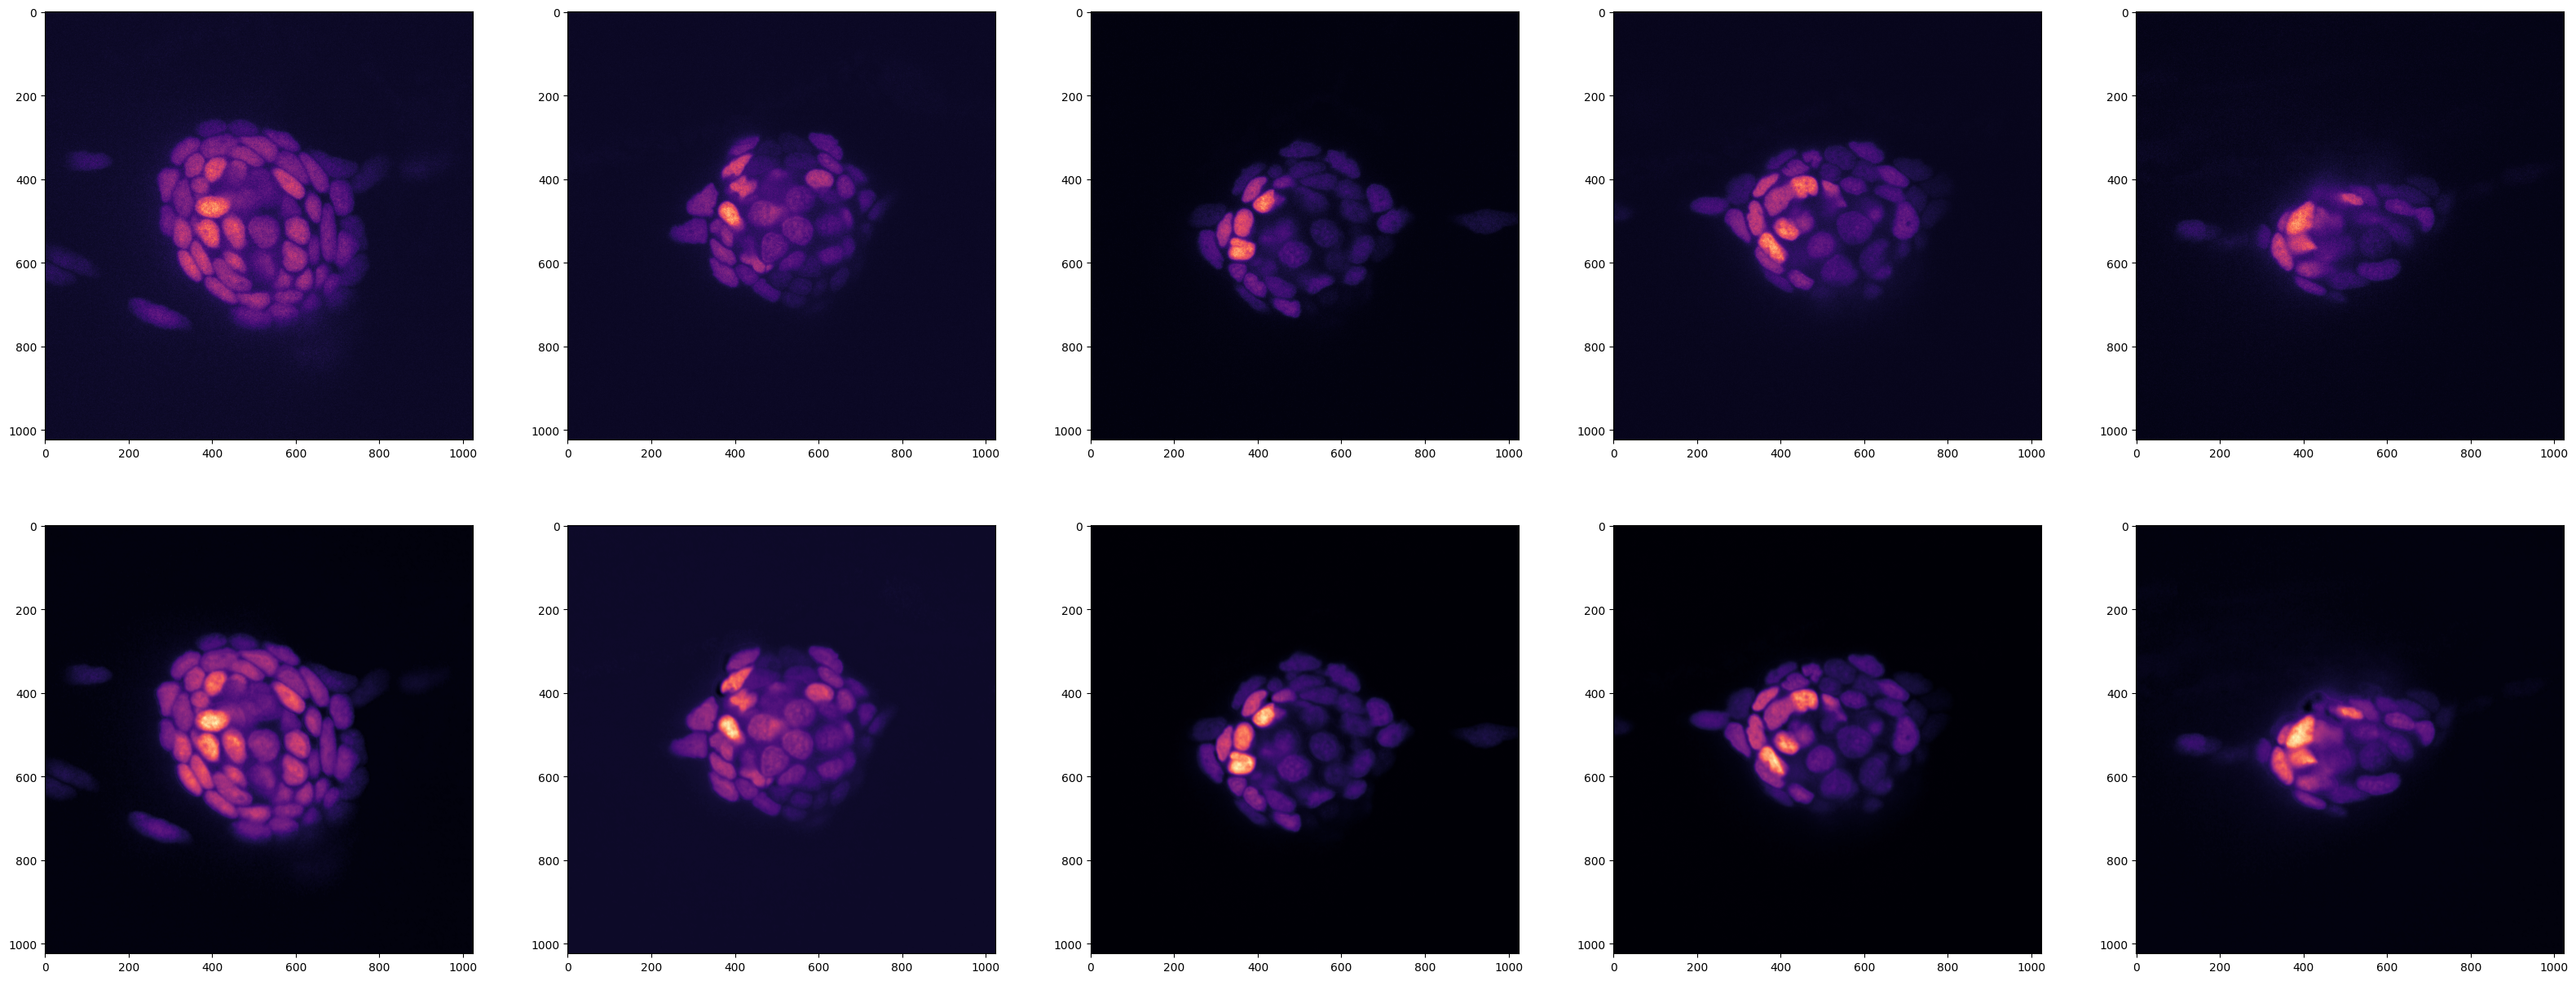

In [42]:
fig, ax = plt.subplots(2,5, figsize=(40,15))
for i in range(len(predictions)):
    ax[0][i].imshow(test_img[i,0,32,...,0],cmap='magma')
    ax[1][i].imshow(predictions[i][32,:,:], cmap='magma')


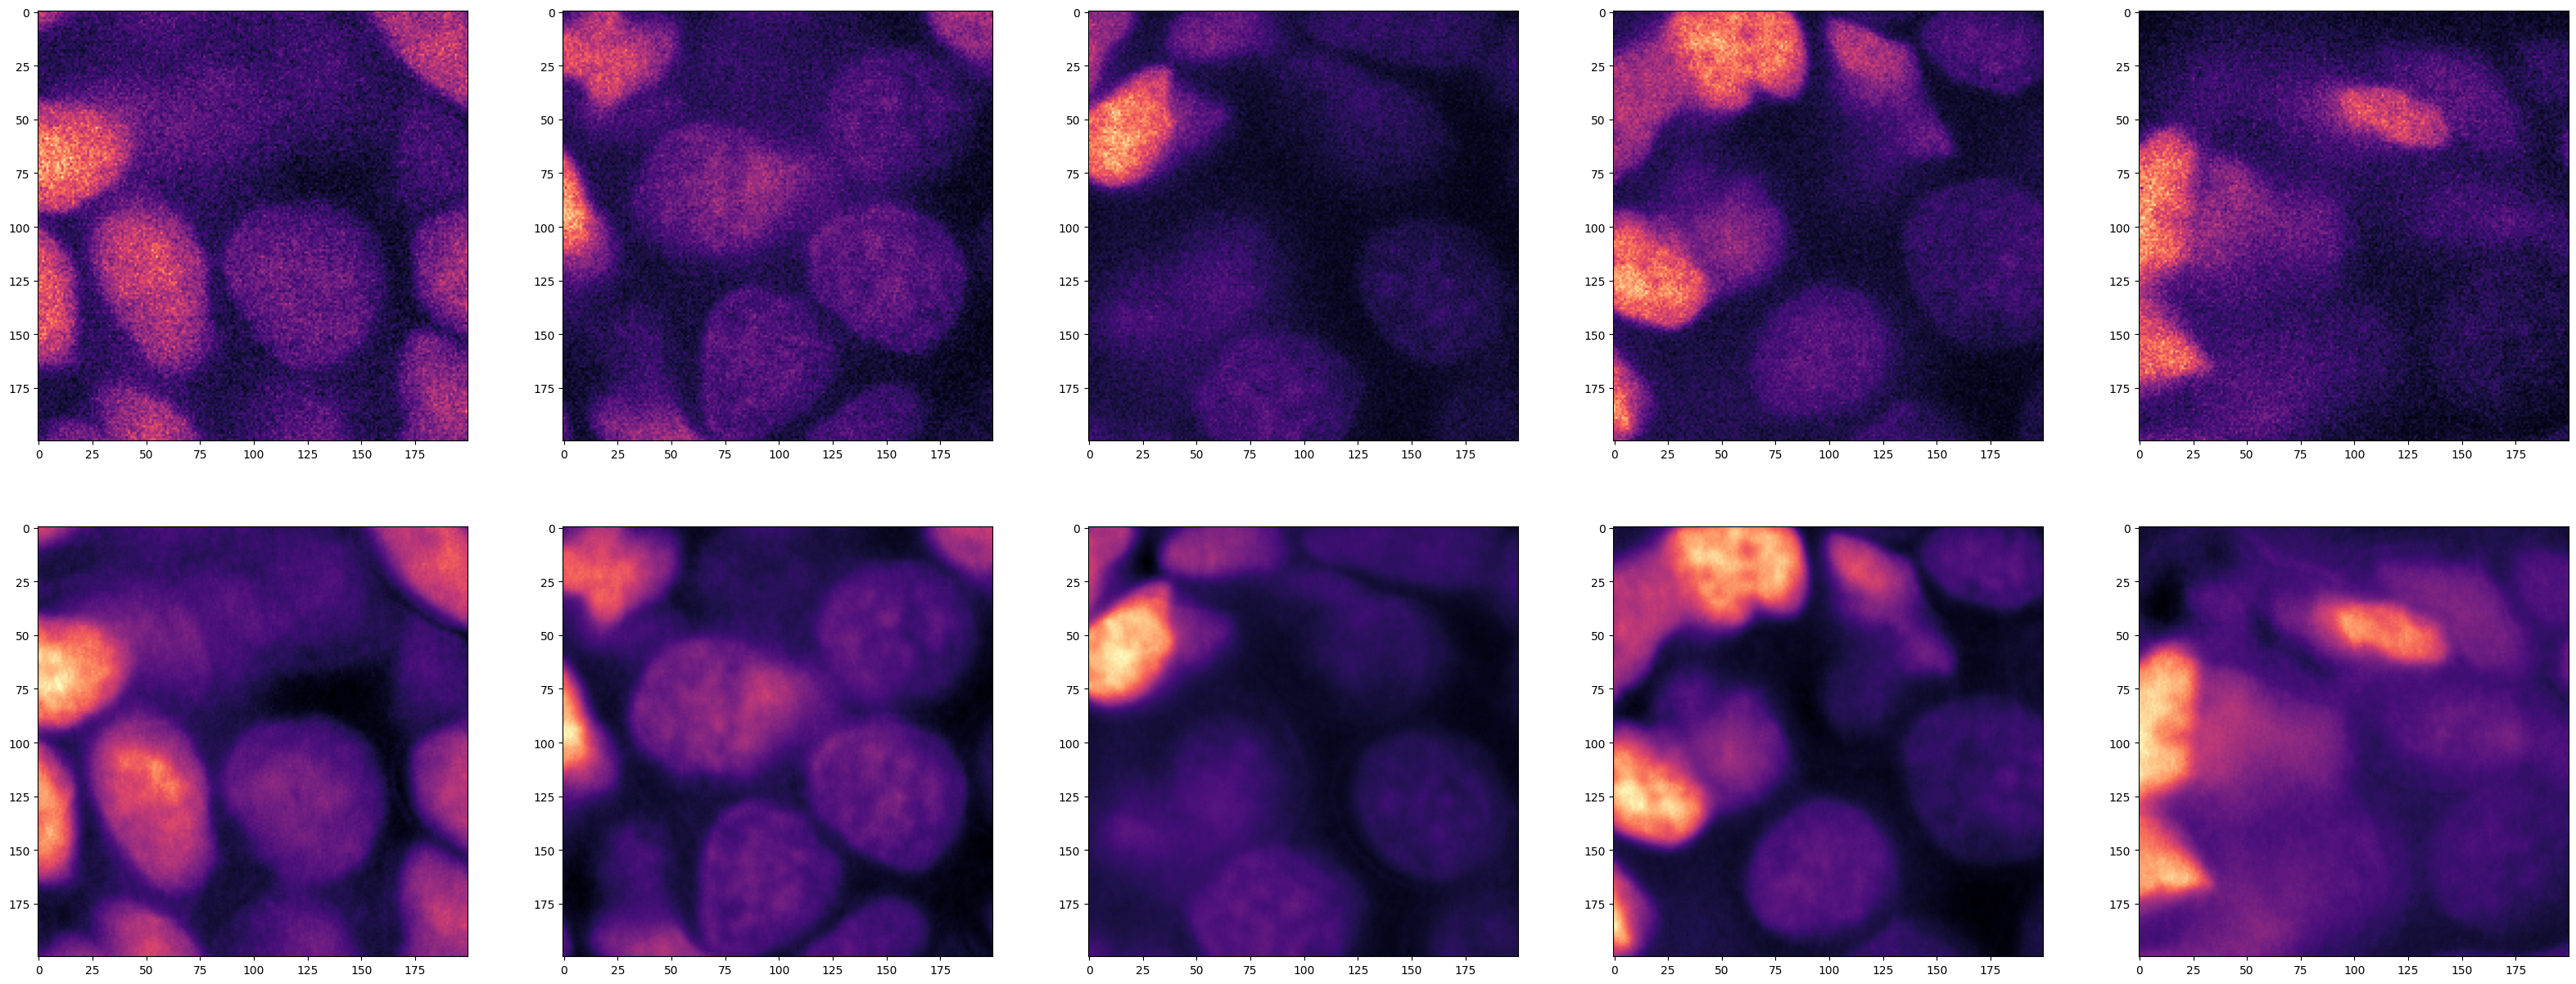

In [43]:
fig, ax = plt.subplots(2,5, figsize=(40,15))
for i in range(len(predictions)):
    ax[0][i].imshow(test_img[i,0,32,400:600,400:600,0],cmap='magma')
    ax[1][i].imshow(predictions[i][32,400:600,400:600], cmap='magma')

In [47]:
import tifffile as tiff
for i in range(len(predictions)):
    tiff.imwrite(f'/mnt/efs/shared_data/hack/data/20230811/n2v_20230902/{i}.tiff', predictions[i])

In [46]:
#!mkdir '/mnt/efs/shared_data/hack/data/20230811/n2v_20230902/'

In [88]:
import tifffile as tiff
tiff.imwrite('data/neuromast/predicted.tif', test_denoised)

In [57]:
###TODO###
ssi_input = structural_similarity(test_img[0,0,...,0], predictions[0])  # TODO
#ssi_restored = structural_similarity(predictions[0])  # TODO
print(
    f"Structural similarity index (higher is better) wrt average of 4x5us images: \n"
    f"Input: {ssi_input} \n"
    #f"Prediction: {ssi_restored}"
)
psnr_input = peak_signal_noise_ratio(predictions[0],test_img[0,0,...,0], data_range=1000)  # TODO
#psnr_restored = peak_signal_noise_ratio(predictions[0])  # TODO
print(
    f"Peak signal-to-noise ratio (higher is better) wrt average of 4x5us images:\n"
    f"Input: {psnr_input} \n"
   # f"Prediction: {psnr_restored}"
)

Structural similarity index (higher is better) wrt average of 4x5us images: 
Input: 0.09251660651072008 

Peak signal-to-noise ratio (higher is better) wrt average of 4x5us images:
Input: 33.15773819469295 

